In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import Analysis

In [3]:
list_sujet = ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12']
nb_sujet = len(list_sujet)

In [4]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)
            
BET = {}
for x in range(len(liste)) :
    if liste[x][0]=='bet' and liste[x][1] in list_sujet:
        a = '../data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            BET[liste[x][1]] = b

In [5]:
e = Analysis(observer='s01', mode='eyeMvt')
Full = e.Full_list(modes_bcp=None)

# Scaling Data

In [6]:
file = os.path.join('parametre', 'Data_Scaling.pkl')
with open(file, 'rb') as fichier:
    new_data = pickle.load(fichier, encoding='latin1')

In [7]:
new_bet_full = new_data['new_bet_full']
new_bet_sujet = new_data['new_bet_sujet']
new_va_full = new_data['new_va_full']
new_va_sujet = new_data['new_va_sujet']

# KL_distance

In [8]:
def KL_distance(p_data, p_hat):
    distance = p_hat * np.log2(p_hat) - p_hat * np.log2(p_data + 1.*(p_data==0.))
    distance += (1-p_hat) * np.log2(1-p_hat) - (1-p_hat) * np.log2(1-p_data + 1.*(p_data==1.))
    return distance

## evaluating the best hazard rate using a likelihood score between the predicted biases using different values of the hazard rate

In [9]:
def plot_evaluating(ax, data, p):

    mean_d = []
    liste = [0,50,100,150,200]
    for a in range(len(liste)-1) :
        
        data_p = data[liste[a]:liste[a+1]]
        p_p = p[liste[a]:liste[a+1]]
        
        distance = KL_distance(data_p, p_p)

        mean_d.append(np.mean(distance))
        distance = np.exp(-distance/np.median(distance))

        tri = range(len(p))[liste[a]:liste[a+1]]
        ax.text(liste[a]+25, 1.15, round(np.mean(distance), 3))
        ax.scatter(tri, data_p, c=distance, vmin=distance.min(), vmax=distance.max(), alpha=1., cmap=plt.get_cmap('RdGy'))  # coolwarm 
    
    trials = range(len(p))

    ax.plot(trials, data, c='k', lw=1, alpha=.9)
    ax.fill_between(trials, np.zeros_like(p), p, lw=.5, alpha=0.2, facecolor='k', step='pre')
    ax.set_ylim(-0.1, 1.1)
    
    return ax, mean_d

In [10]:
import matplotlib.gridspec as gridspec
liste_data = ['data', 'data_sujet', 'data_full']
def evaluating (ev):
    
    mean_d = {}
    for d in liste_data :
        mean_d[d] = {}
    
    for x, sujet in enumerate(list_sujet) :
        print(sujet)

        for d in liste_data :
            mean_d[d][sujet] = [[],[],[]]
        
        fig = plt.figure(figsize=(20,20/3))
        axs = gridspec.GridSpec(3, 1, hspace=0.6)

        mode = 'mean'

        N_trials, N_blocks = BET[sujet]['N_trials'], BET[sujet]['N_blocks']
            
        nb_trial = 0
        for block in range(N_blocks) :
            gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=axs[block], wspace=0.2)
            ax1 = plt.Subplot(fig, gs1[0])
            ax2 = plt.Subplot(fig, gs1[1])
            ax3 = plt.Subplot(fig, gs1[2])
            fig.add_subplot(ax1)
            fig.add_subplot(ax2)
            fig.add_subplot(ax3)
            
            if ev=='bet' :
                data = np.array((BET[sujet]['results'][:,block]+1)/2)
                data_sujet = np.array(new_bet_sujet[sujet][block])
                data_full = np.array(new_bet_full[sujet][block])
            else :
                data = np.array(list(Full['va'][Full.sujet==sujet])[nb_trial : N_trials + nb_trial*block])
                data_sujet = np.array(new_va_sujet[sujet][block])
                data_full = np.array(new_va_full[sujet][block])
                
            p = np.array(list(Full['proba'][Full.sujet==sujet])[nb_trial:N_trials+nb_trial*block])

            ax1, mean_d['data'][sujet][block] = plot_evaluating(ax1, data, p)
            ax2, mean_d['data_sujet'][sujet][block] = plot_evaluating(ax2, data_sujet, p)
            ax3, mean_d['data_full'][sujet][block] = plot_evaluating(ax3, data_full, p)
            
            if block==0 :
                ax1.set_title('data\n\n')
                ax2.set_title('data_sujet\n\n')
                ax3.set_title('data_full\n\n')

            nb_trial = nb_trial+N_trials

        plt.show()
    return mean_d

s01


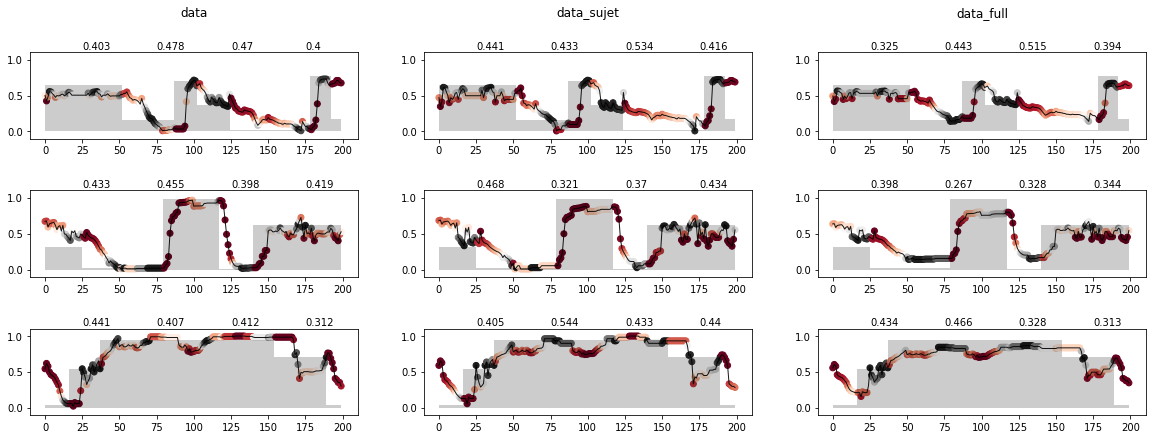

s02


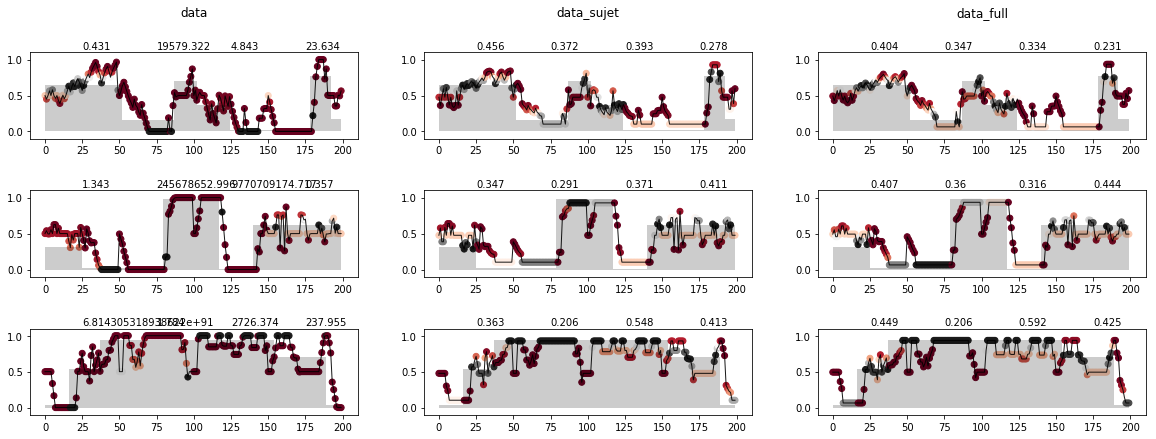

s03


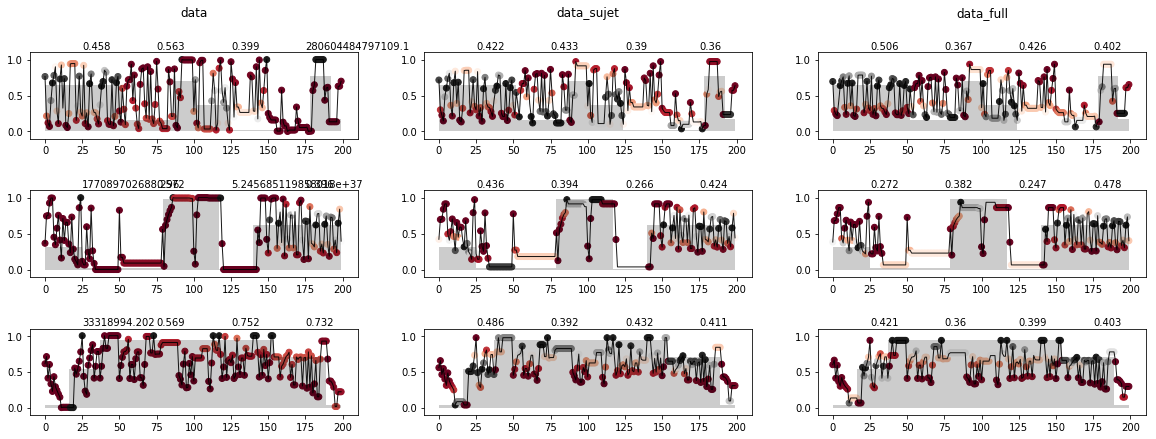

s04


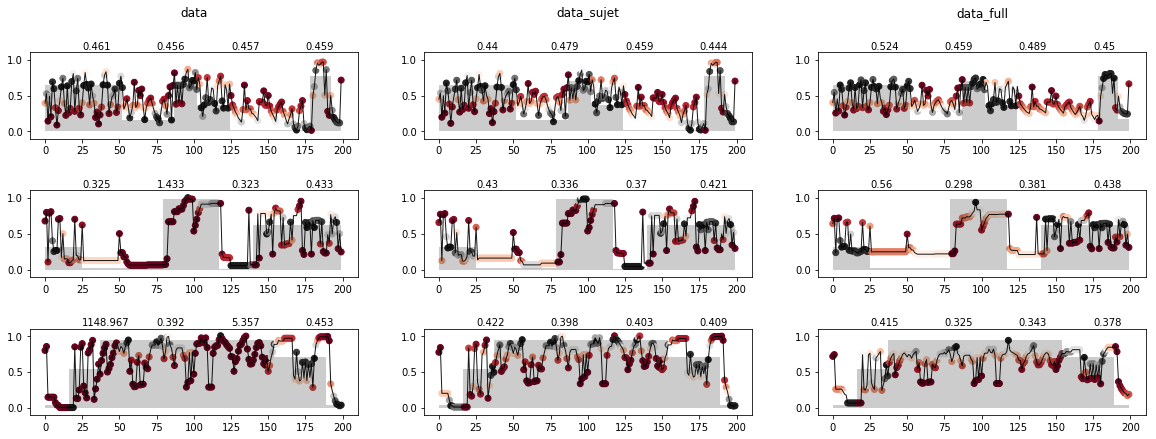

s05


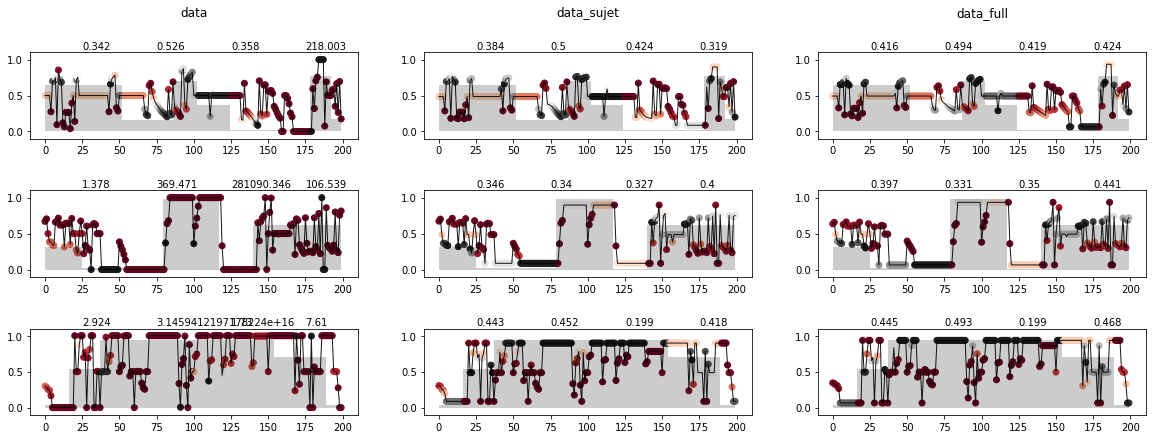

s06


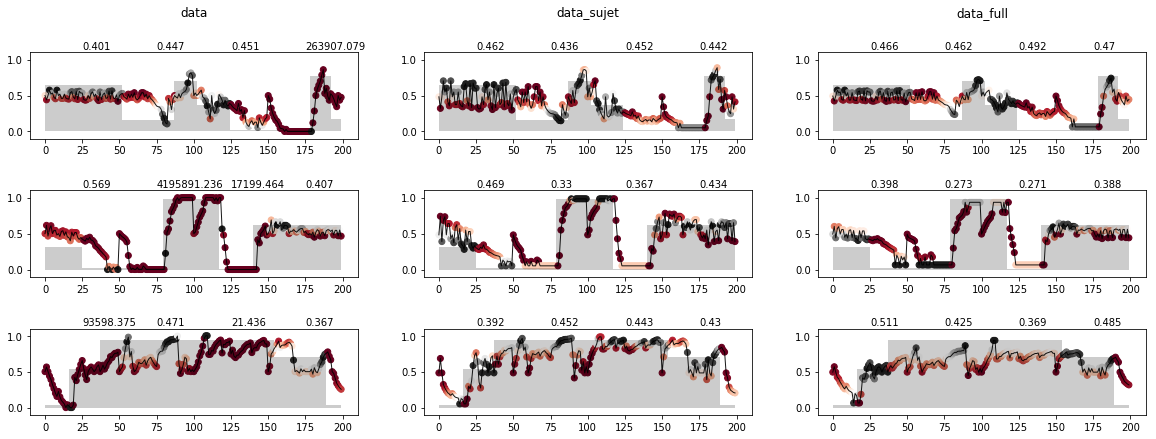

s07


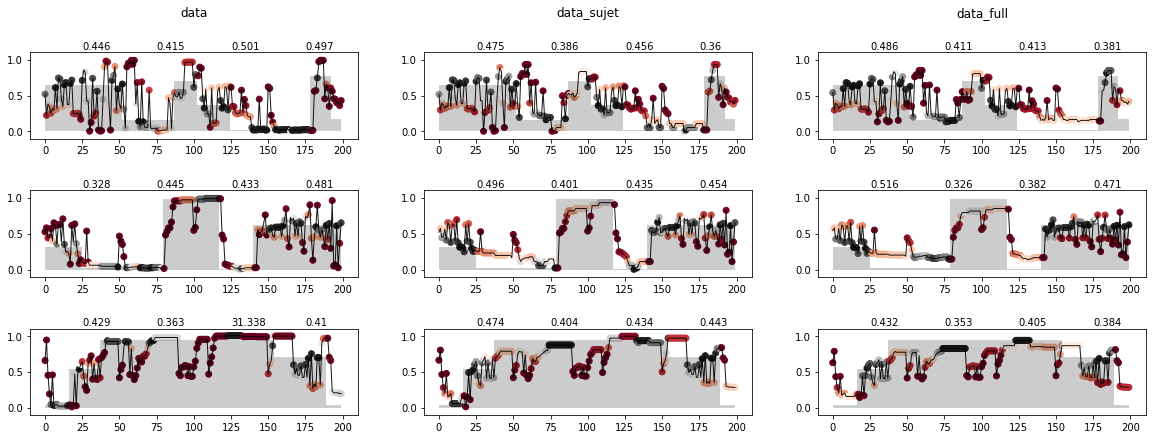

s08


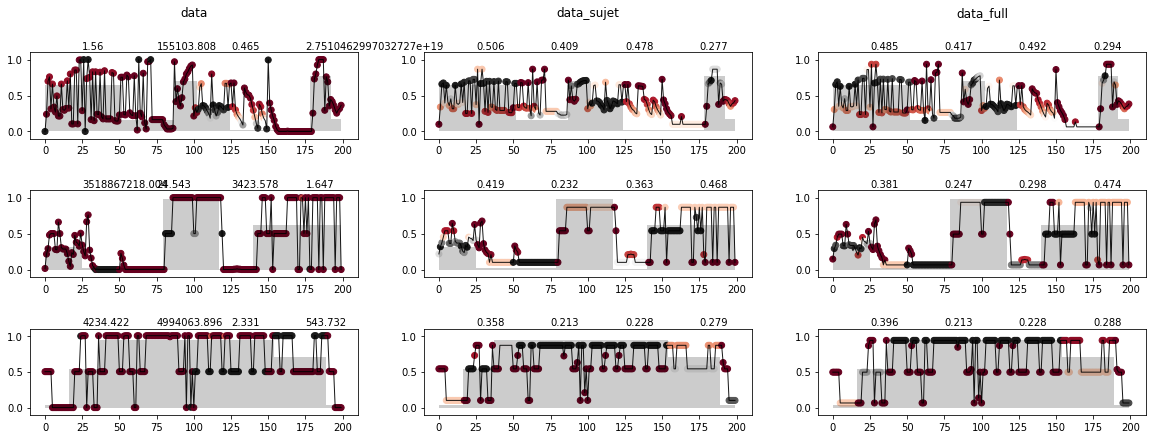

s09


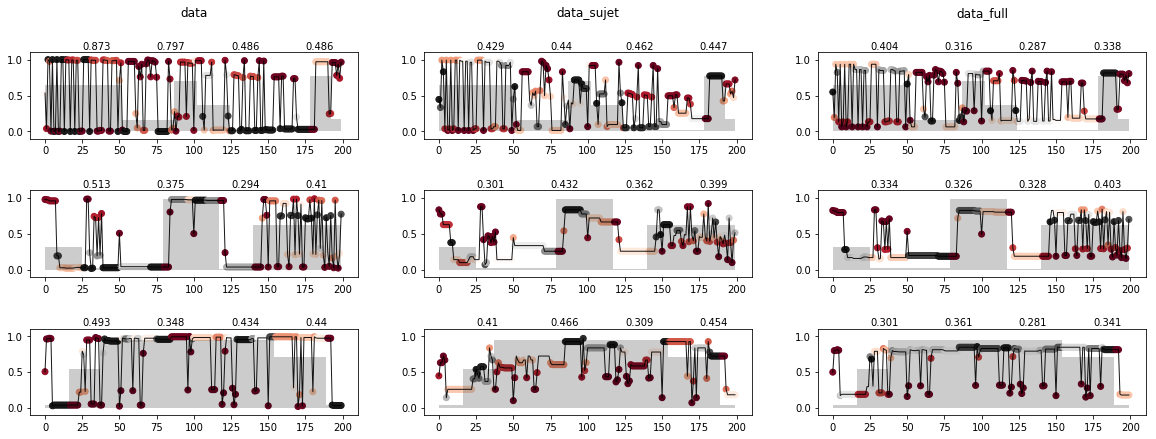

s10


/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


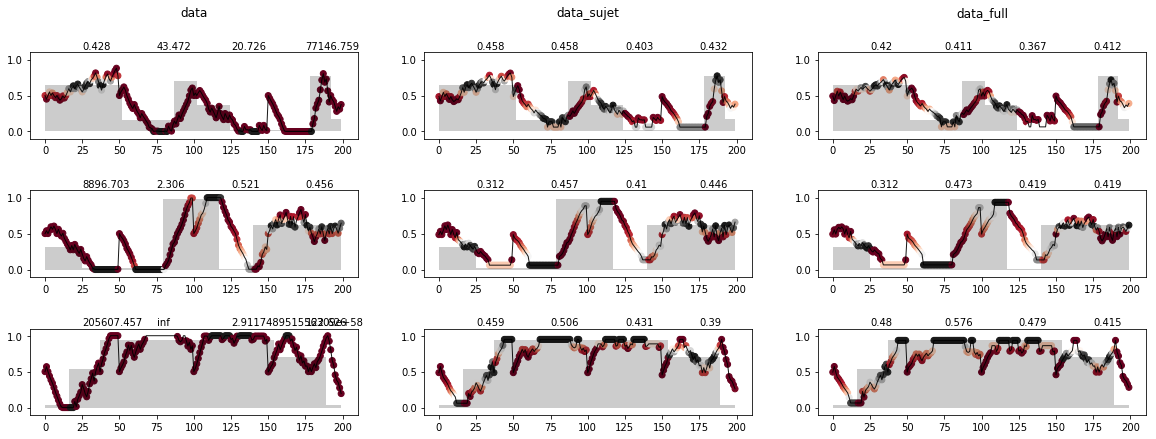

s11


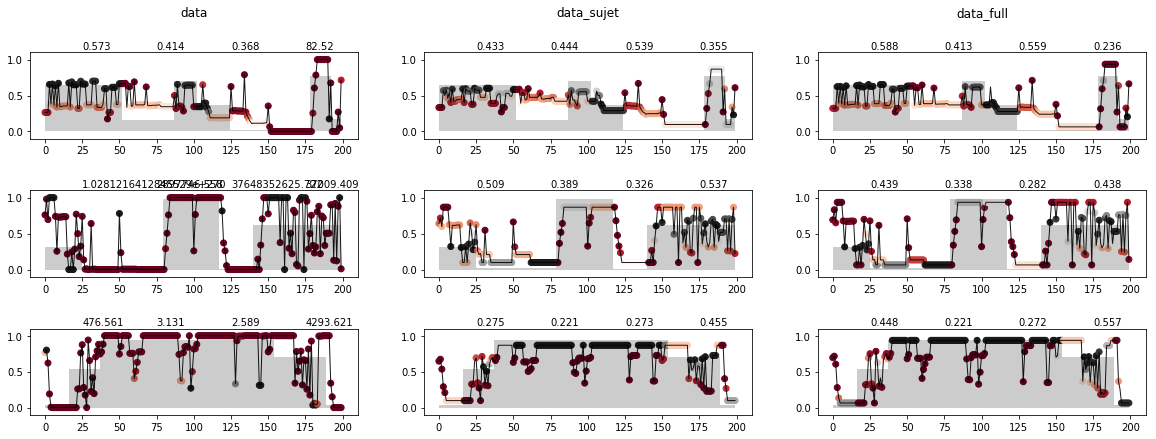

s12


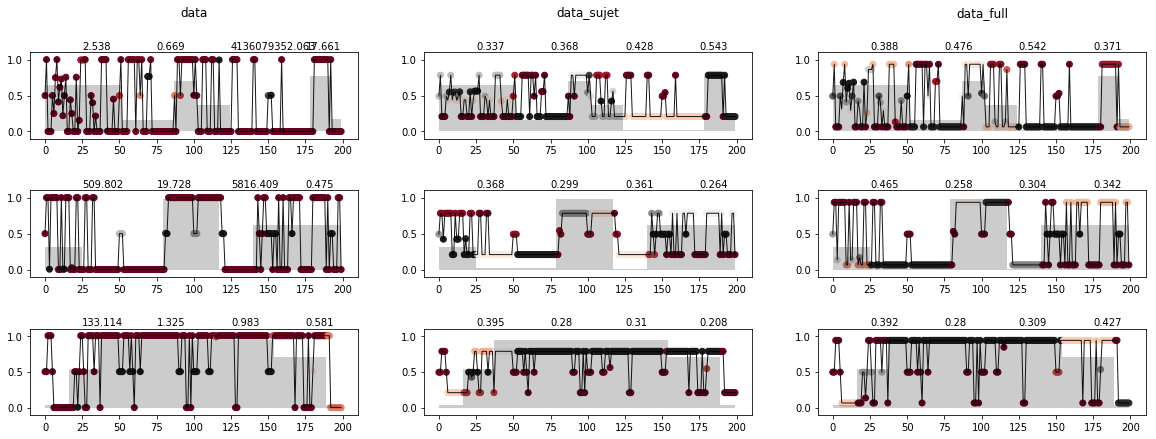

In [11]:
mean_d_bet = evaluating ('bet')

s01


/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


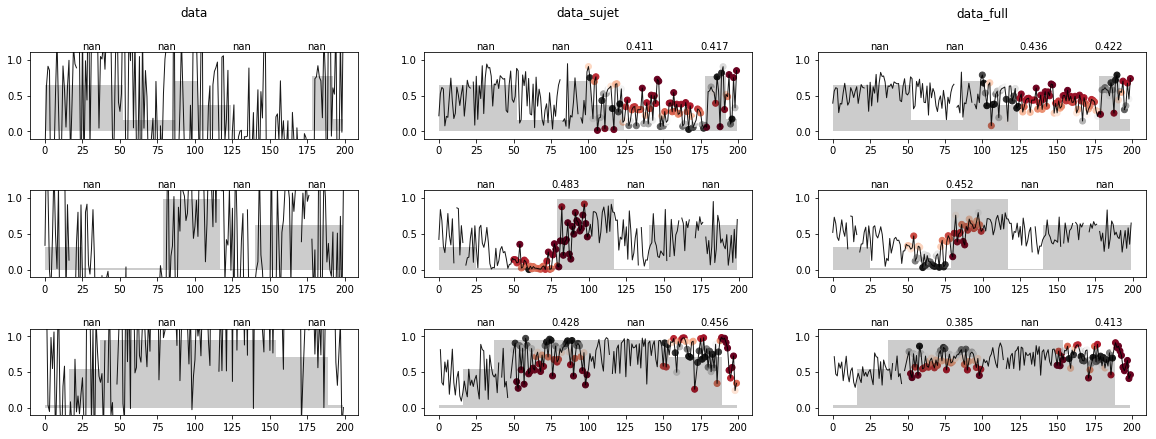

s02


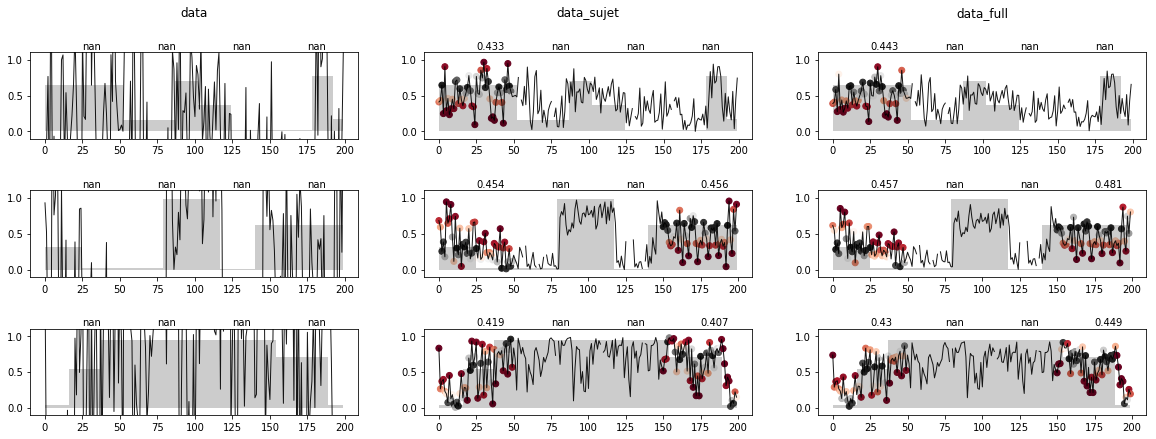

s03


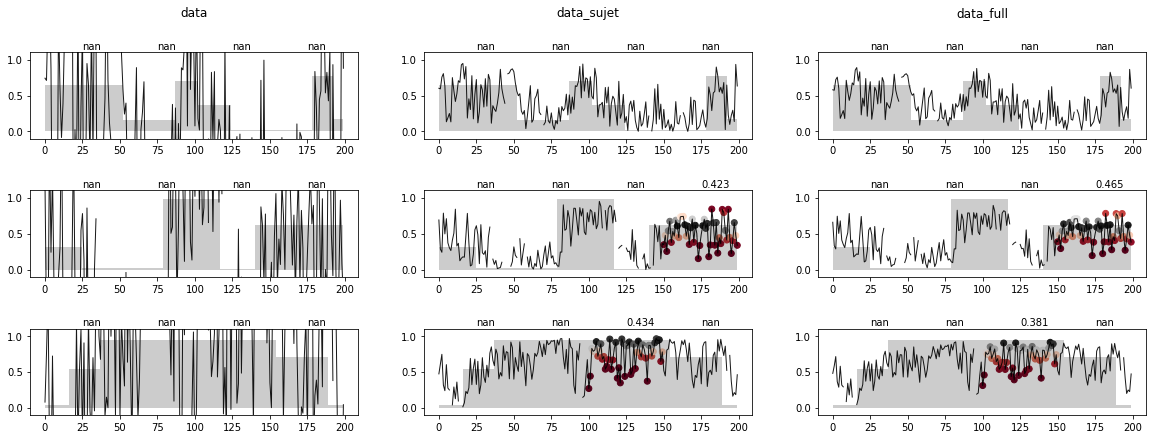

s04


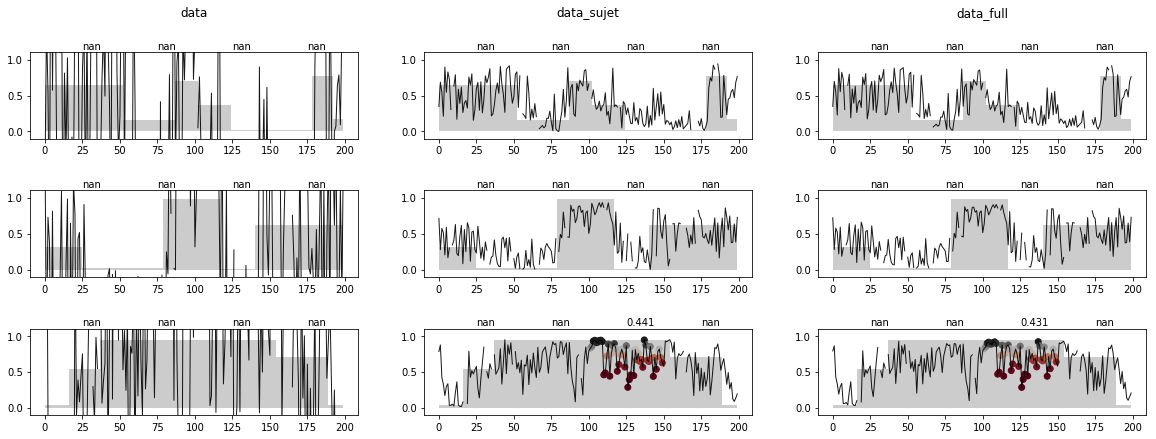

s05


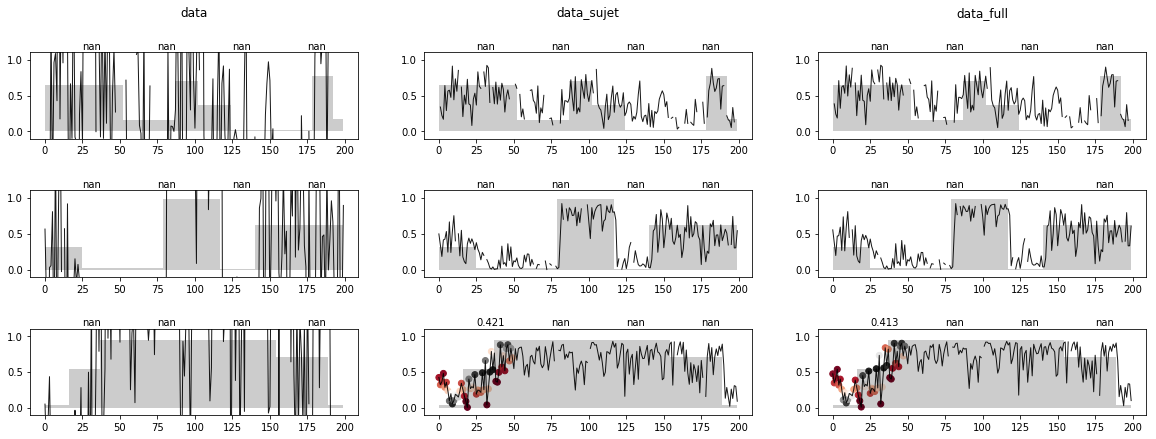

s06


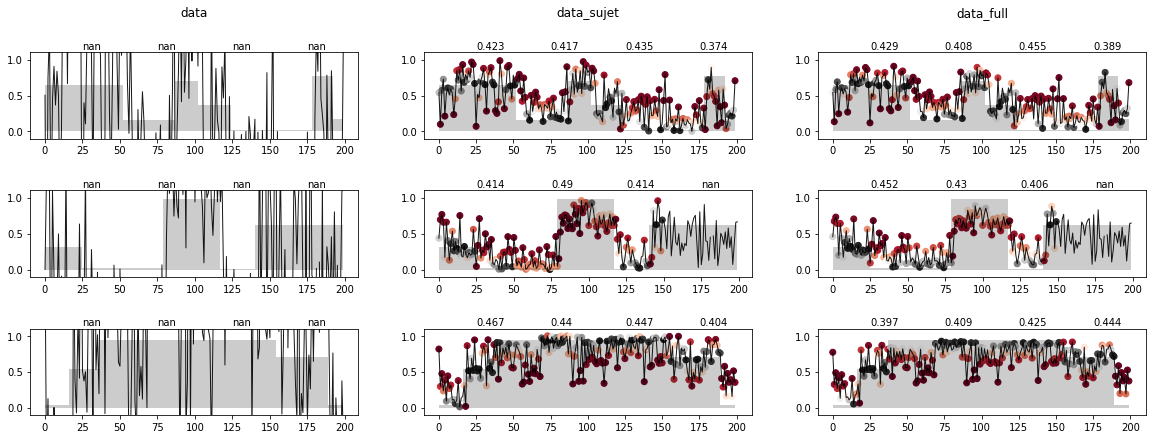

s07


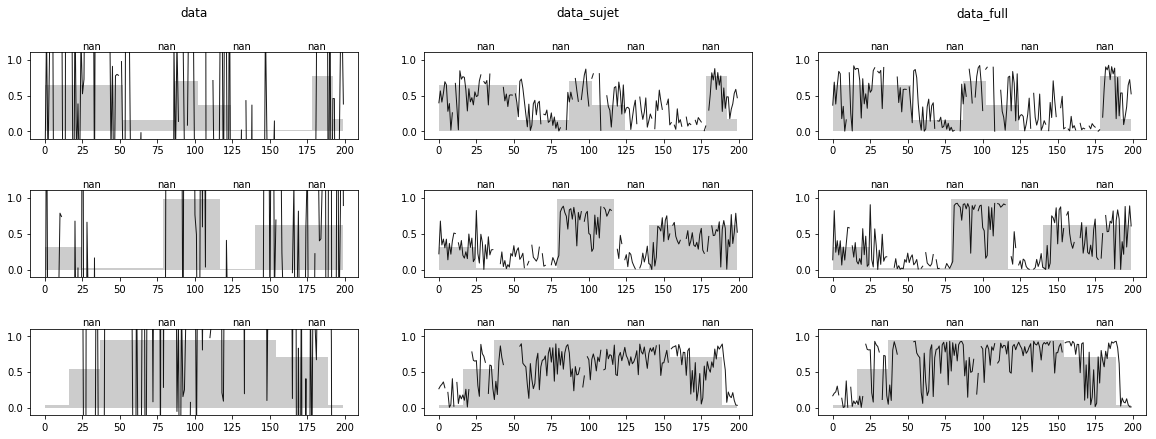

s08


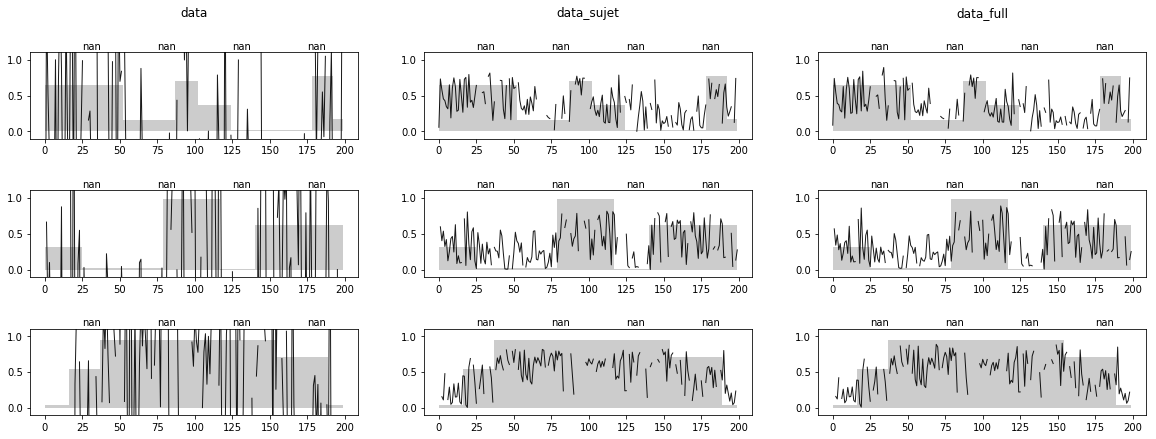

s09


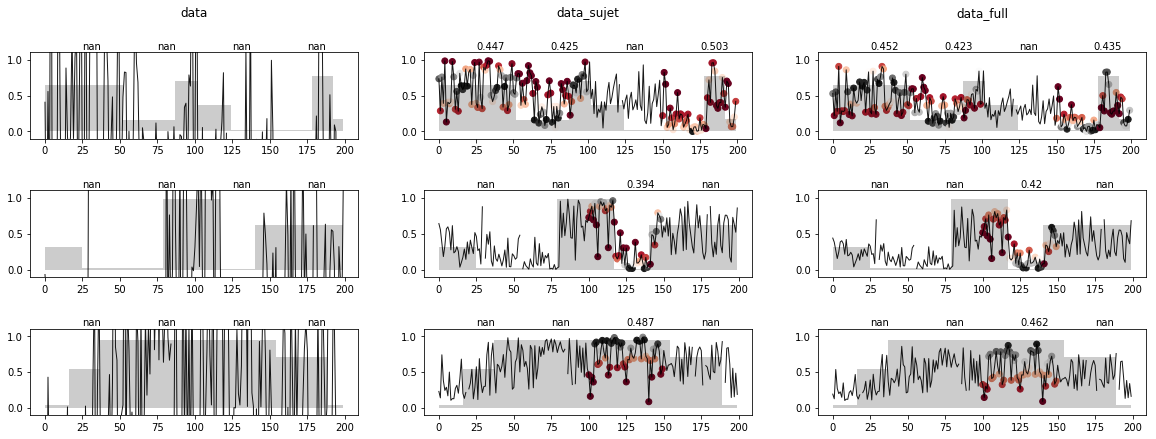

s10


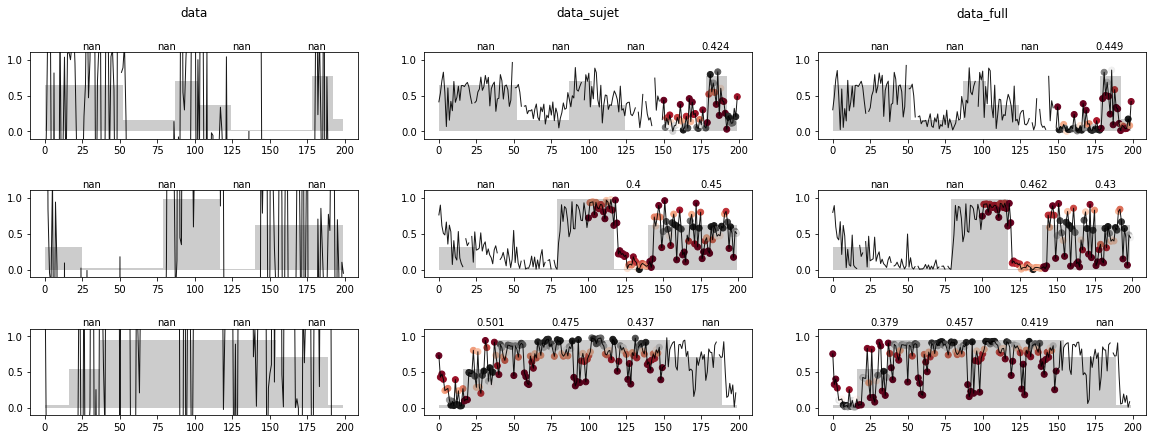

s11


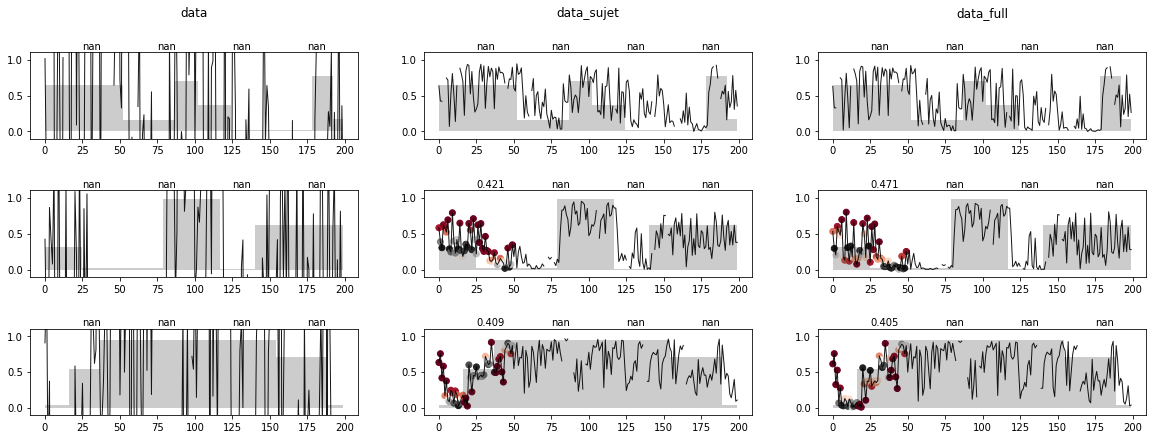

s12


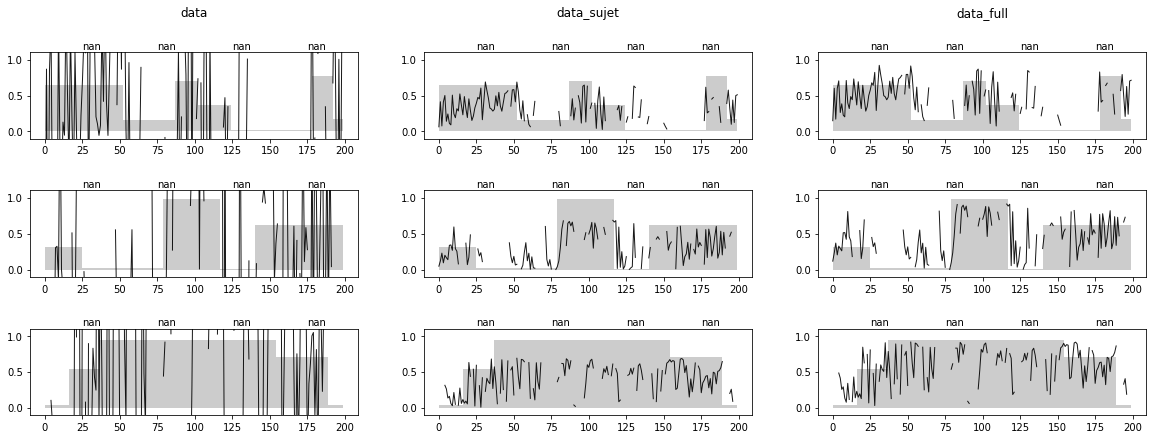

In [12]:
mean_d_va = evaluating ('va')

In [13]:
def plot_app(mean_d):
    mean_mean_d = {}
    for data in liste_data :
        mean_mean_d[data] = [[], [], []]
    fig1, axs1 = plt.subplots(1, 3,figsize=(15,3))
    fig, axs = plt.subplots(len(list_sujet), 3,figsize=(15,30))
    c = ['k', 'grey', 'r']
    l = [0,4,8,12]
    
    l_mean_mean_d_block = {}
    for d, data in enumerate(liste_data) :
        l_mean_mean_d_block[data] = []
    
    
    for x, sujet in enumerate(list_sujet) :
        l_mean_d_block = {}
        for d, data in enumerate(liste_data) :
            l_mean_d_block[data] = []
        N_blocks = BET[sujet]['N_blocks']
        
        for block in range(N_blocks) :

            axs[x][0].set_ylabel(sujet)
            
            for d, data in enumerate(liste_data) :
                l_mean_d_block[data].extend(mean_d[data][sujet][block])
                axs[x][d].scatter(range(l[block], l[block+1]), mean_d[data][sujet][block], c=c[block], s=20)
                mean_mean_d[data][block].append(mean_d[data][sujet][block])
        
        for d, data in enumerate(liste_data) :
            axs[x][d].plot(l_mean_d_block[data], c='k', ls='--', alpha=0.5)
            
            #axs[x][d].axis([-0.5,11.5,-1,1])

    for d, data in enumerate(liste_data) :
        for block in range(N_blocks) :
            l_mean_mean_d_block[data].extend(np.mean(mean_mean_d[data][block], 0))
            axs1[d].scatter(range(l[block], l[block+1]), np.mean(mean_mean_d[data][block], 0), c=c[block], s=20)
        axs1[d].plot(l_mean_mean_d_block[data], c='k', ls='--', alpha=0.5)
        
        
        axs[0][d].set_title(data)
        axs1[d].set_title(data)
        #axs1[d].axis([-0.5,11.5,-1,1])
    
    axs1[0].set_ylabel('mean')

    plt.show()

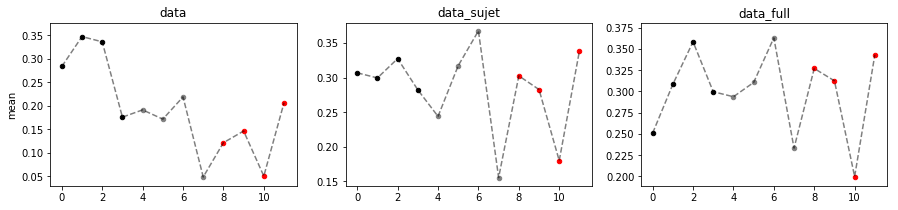

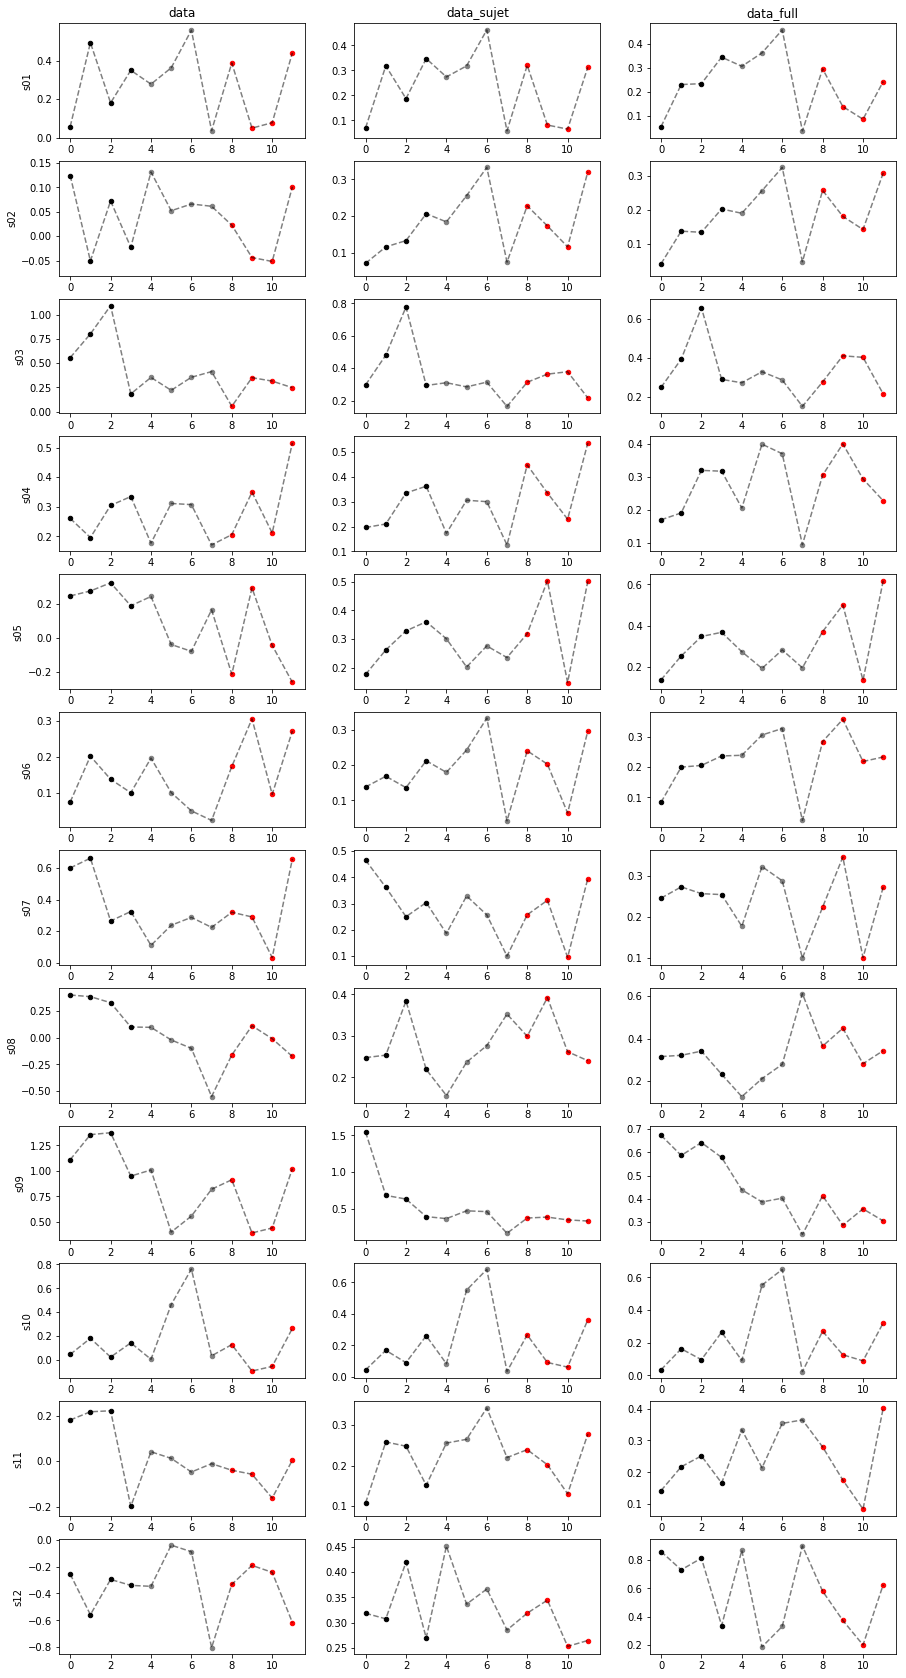

In [14]:
plot_app(mean_d_bet)

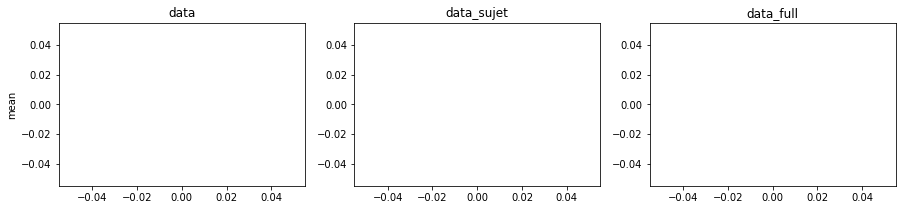

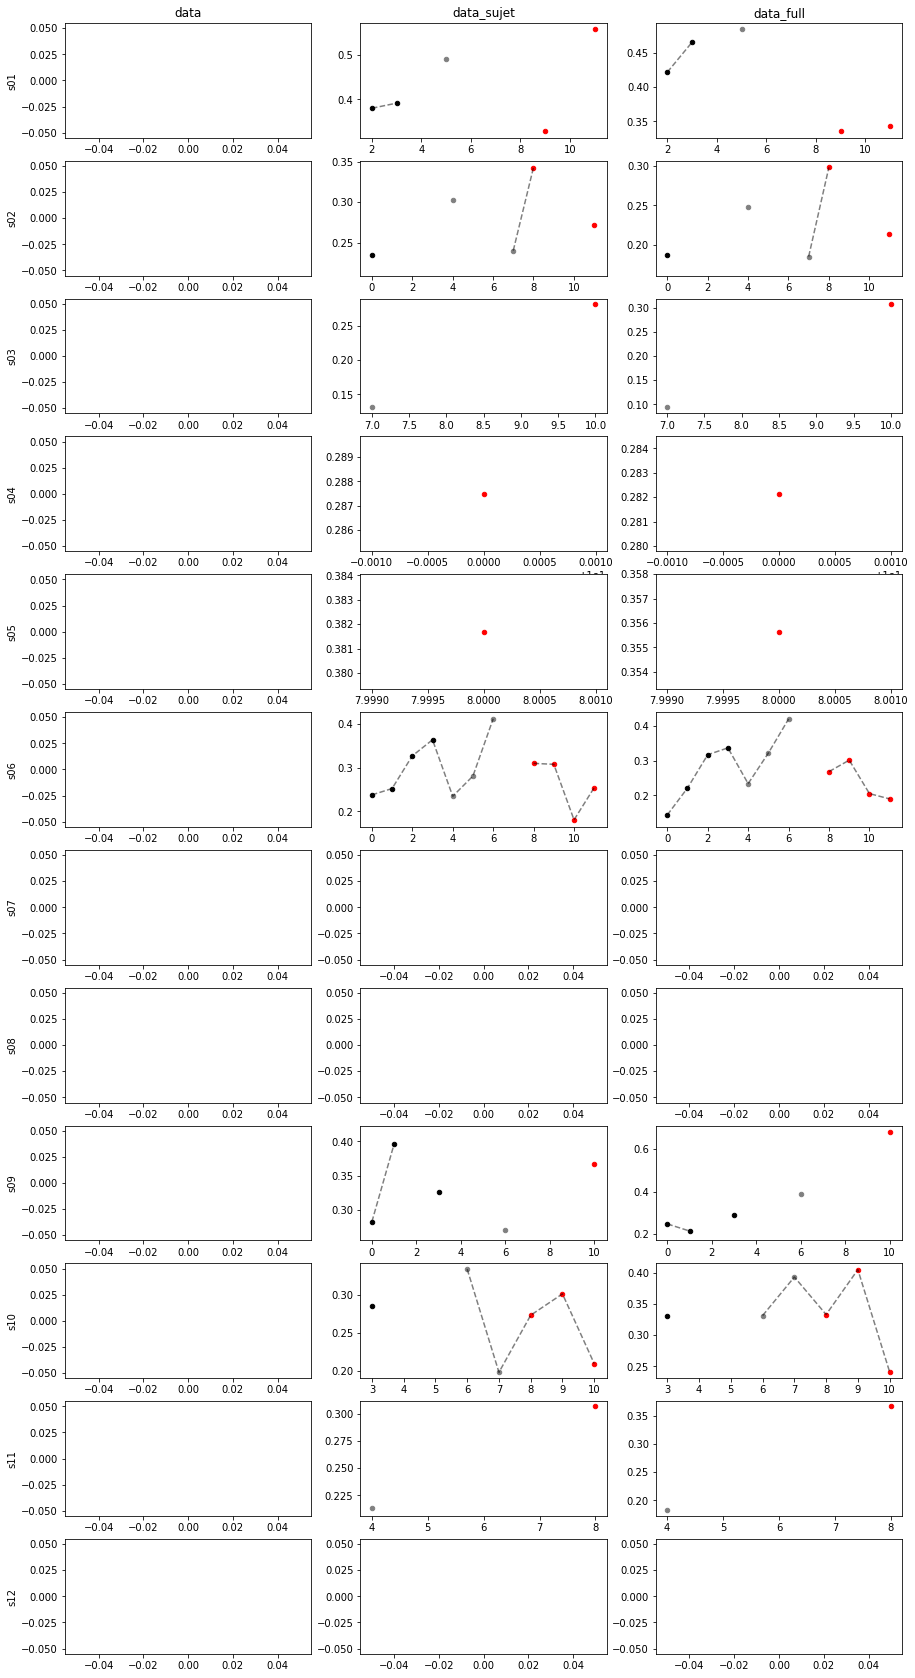

In [15]:
plot_app(mean_d_va)